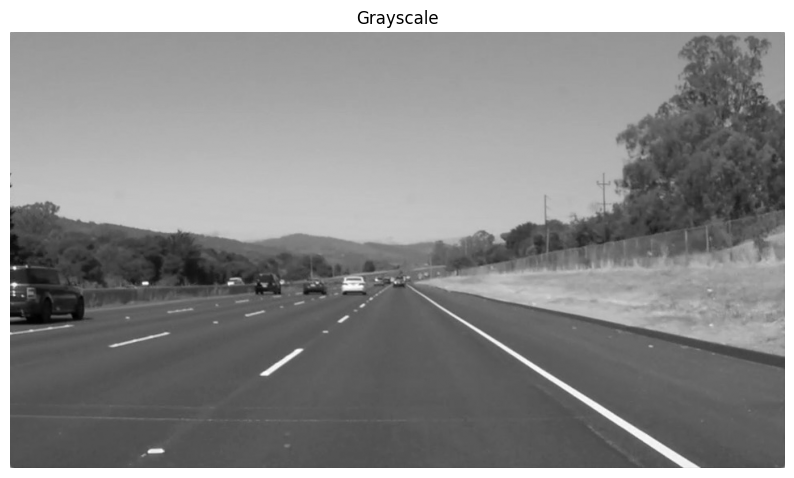

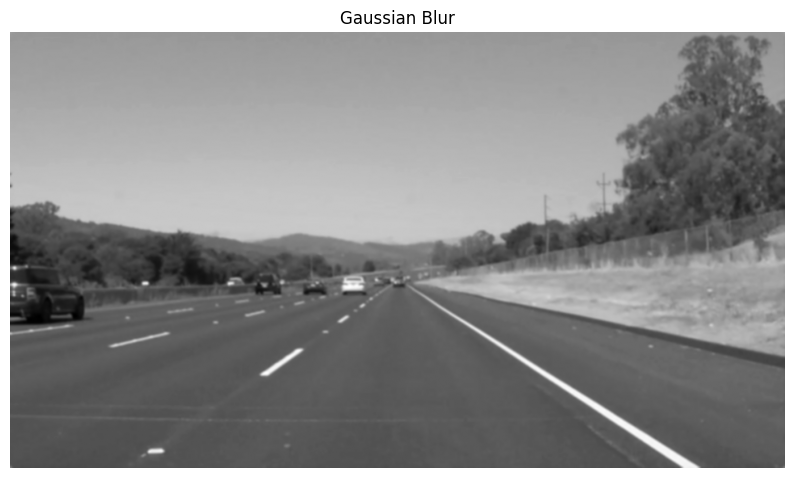

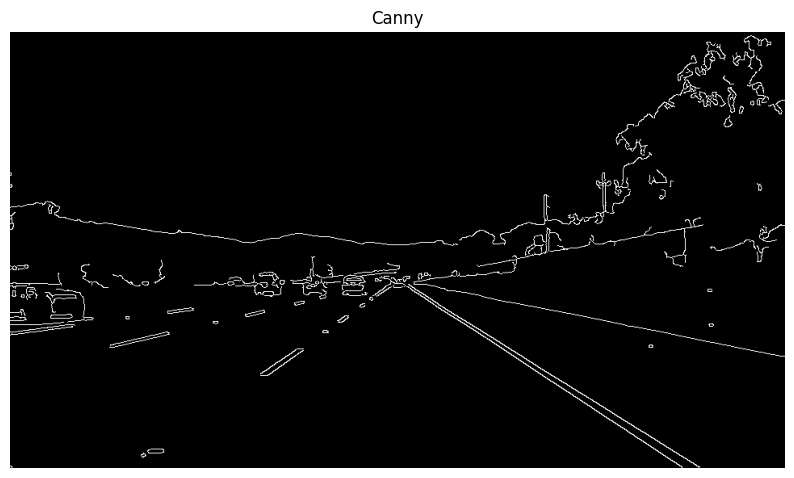

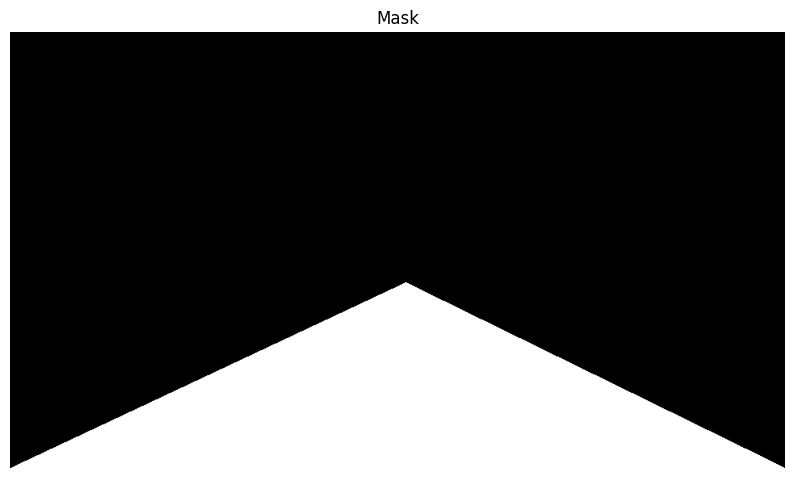

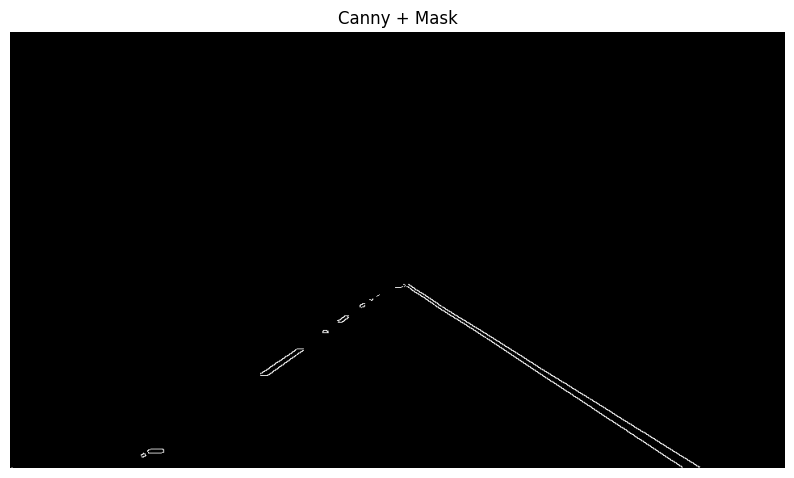

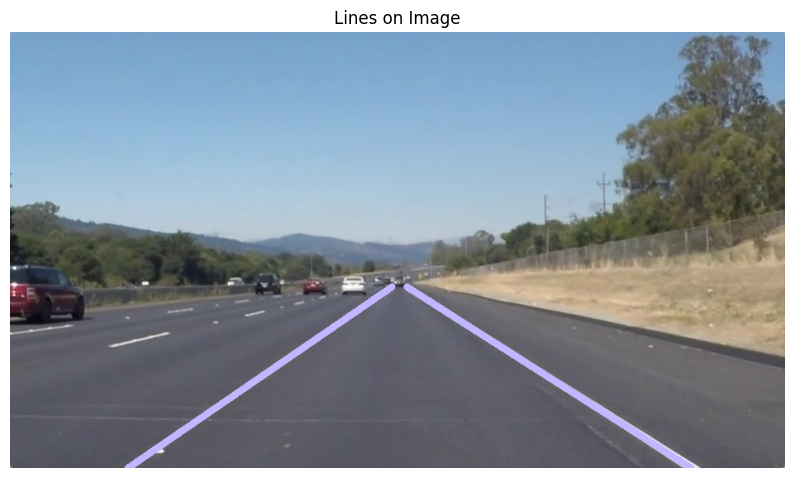

Відео збережено як 'output_video_lines.mp4'


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Функція для відображення зображення в Jupyter
def show_img(img, title='Image', cmap_type='gray'):
    plt.figure(figsize=(10, 6))
    if len(img.shape) == 3:  # кольорове зображення
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
    else:
        plt.imshow(img, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

# ------------------- Обробка фото ---------------------

img = cv2.imread('road2.jpg')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gauss = cv2.GaussianBlur(gray, (5, 5), 0)
canny = cv2.Canny(gauss, 30, 150)

vert = np.array([[ (0, img.shape[0]), (490, 310), (490, 310), (img.shape[1], img.shape[0])]], dtype=np.int32)
mask = np.zeros_like(canny)
cv2.fillPoly(mask, vert, 255)
mask_img = cv2.bitwise_and(canny, mask)

def draw_lines(img, lines, color=[255,182,193], thick=8):
    x_bot_pos, x_upp_pos, x_bot_neg, x_upp_neg = [], [], [], []
    y_bot = 540
    y_upp = 315

    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2 == x1:
                continue  # уникнути ділення на нуль
            slope = (y2 - y1) / (x2 - x1)
            b = y1 - slope * x1

            if 0.5 < slope < 0.8:
                x_bot_pos.append((y_bot - b) / slope)
                x_upp_pos.append((y_upp - b) / slope)
            elif -0.8 < slope < -0.5:
                x_bot_neg.append((y_bot - b) / slope)
                x_upp_neg.append((y_upp - b) / slope)

    lines_mean = np.array([
        [int(np.mean(x_bot_pos)), y_bot, int(np.mean(x_upp_pos)), y_upp],
        [int(np.mean(x_bot_neg)), y_bot, int(np.mean(x_upp_neg)), y_upp]
    ])

    for x1, y1, x2, y2 in lines_mean:
        cv2.line(img, (x1, y1), (x2, y2), color, thick)

rho = 1
theta = np.pi/180
threshold = 15
min_line_len = 10
max_line_gap = 60

lines = cv2.HoughLinesP(mask_img, rho, theta, threshold, np.array([]),
                        minLineLength=min_line_len, maxLineGap=max_line_gap)

draw_lines(img, lines)

# Відображення результатів
show_img(gray, 'Grayscale')
show_img(gauss, 'Gaussian Blur')
show_img(canny, 'Canny')
show_img(mask, 'Mask')
show_img(mask_img, 'Canny + Mask')
show_img(img, 'Lines on Image')

# ------------------- Обробка відео ---------------------

vid = cv2.VideoCapture('road.mp4')
if not vid.isOpened():
    print("Не вдалося відкрити відео.")
else:
    frame_width = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(vid.get(cv2.CAP_PROP_FPS))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter('output_video_lines.mp4', fourcc, fps, (frame_width, frame_height))

    while True:
        ret, frame = vid.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gauss = cv2.GaussianBlur(gray, (5, 5), 0)
        canny = cv2.Canny(gauss, 30, 150)

        vert = np.array([[ (0, frame.shape[0]), (490, 310), (490, 310), (frame.shape[1], frame.shape[0]) ]], dtype=np.int32)
        mask = np.zeros_like(canny)
        cv2.fillPoly(mask, vert, 255)
        mask_img = cv2.bitwise_and(canny, mask)

        lines = cv2.HoughLinesP(mask_img, 1, np.pi/180, 15, np.array([]), minLineLength=10, maxLineGap=60)
        draw_lines(frame, lines)

        out.write(frame)

    vid.release()
    out.release()
    print("Відео збережено як 'output_video_lines.mp4'")